## SECTION 1 — Load & clean the dataset

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pyddm
from pyddm import Model, Fittable, Sample
from pyddm.models import DriftConstant, NoiseConstant, BoundConstant, OverlayNonDecision

sns.set_style("whitegrid")

df = pd.read_csv("dataset-23 - Copy.tsv", sep="\t")

df.head()

,subjects,S,prime,R,rt
0,1,cat,WOOF,dog,0.369526
1,1,cat,WOOF,dog,0.695785
2,1,dog,WOOF,dog,0.749988
3,1,dog,MEOW,cat,0.372379
4,1,cat,MEOW,cat,0.351478


Basic cleaning

In [3]:
df = df.copy()

# keep only normal RTs
df = df[df["rt"] > 0.15]

# 1 = correct, 0 = wrong
df["choice"] = (df["S"] == df["R"]).astype(int)

# rename conditions
df["cond"] = df["prime"].map({"WOOF": "WOOF", "MEOW": "MEOW"})

# convert subjects to int
df["subjects"] = df["subjects"].astype(int)

df.head()


,subjects,S,prime,R,rt,choice,cond
0,1,cat,WOOF,dog,0.369526,0,WOOF
1,1,cat,WOOF,dog,0.695785,0,WOOF
2,1,dog,WOOF,dog,0.749988,1,WOOF
3,1,dog,MEOW,cat,0.372379,0,MEOW
4,1,cat,MEOW,cat,0.351478,1,MEOW


## SECTION 2 — Behavioral summary

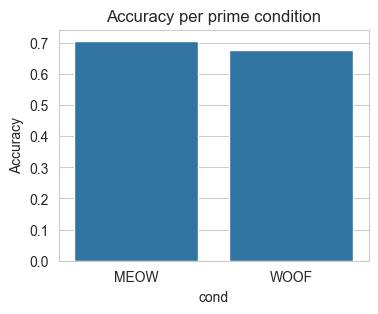

In [4]:
acc = df.groupby("cond")["choice"].mean()

plt.figure(figsize=(4,3))
sns.barplot(x=acc.index, y=acc.values)
plt.title("Accuracy per prime condition")
plt.ylabel("Accuracy")
plt.show()

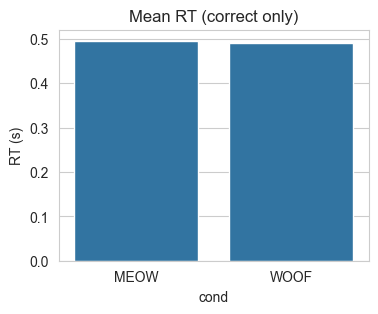

In [5]:
rt = df[df["choice"]==1].groupby("cond")["rt"].mean()

plt.figure(figsize=(4,3))
sns.barplot(x=rt.index, y=rt.values)
plt.title("Mean RT (correct only)")
plt.ylabel("RT (s)")
plt.show()


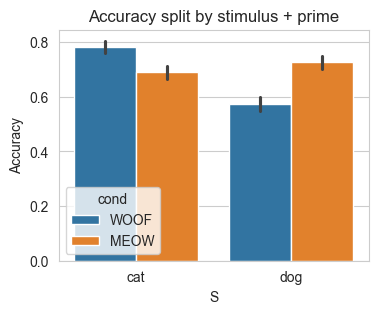

In [6]:
plt.figure(figsize=(4,3))
sns.barplot(data=df, x="S", y="choice", hue="cond")
plt.title("Accuracy split by stimulus + prime")
plt.ylabel("Accuracy")
plt.show()


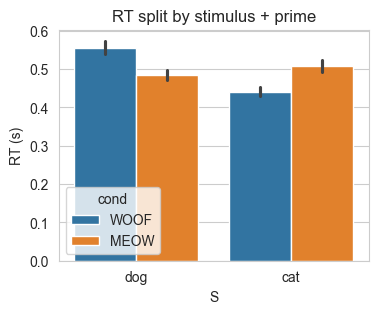

In [7]:
plt.figure(figsize=(4,3))
sns.barplot(data=df[df["choice"]==1], x="S", y="rt", hue="cond")
plt.title("RT split by stimulus + prime")
plt.ylabel("RT (s)")
plt.show()


## SECTION 3 — Prepare data per participant and per condition

In [8]:
participants = sorted(df["subjects"].unique())
participants


[np.int64(1),
 np.int64(2),
 np.int64(3),
 np.int64(4),
 np.int64(5),
 np.int64(6),
 np.int64(7),
 np.int64(8),
 np.int64(9),
 np.int64(10),
 np.int64(11),
 np.int64(12)]

In [9]:
data_sub = {}

for pid in participants:
    data_sub[pid] = {}
    for cond in ["WOOF", "MEOW"]:
        sub_df = df[(df["subjects"] == pid) & (df["cond"] == cond)]
        data_sub[pid][cond] = sub_df.copy()

data_sub[1]["WOOF"].head()


,subjects,S,prime,R,rt,choice,cond
0,1,cat,WOOF,dog,0.369526,0,WOOF
1,1,cat,WOOF,dog,0.695785,0,WOOF
2,1,dog,WOOF,dog,0.749988,1,WOOF
5,1,dog,WOOF,dog,0.381712,1,WOOF
11,1,cat,WOOF,cat,0.244946,1,WOOF


## SECTION 4 — Build a simple DDM

In [10]:
def build_model():
    return Model(
        drift=DriftConstant(drift=Fittable(minval=0.01, maxval=3)),
        noise=NoiseConstant(noise=1.0),   # scaling constant
        bound=BoundConstant(B=Fittable(minval=0.3, maxval=2)),
        overlay=OverlayNonDecision(nondectime=Fittable(minval=0, maxval=0.5)),
        dx=.005, dt=.005, T_dur=3.0
    )


In [11]:
from pyddm import Model, Fittable, Sample
from pyddm.models import DriftConstant, NoiseConstant, BoundConstant, OverlayNonDecision
import numpy as np
import pandas as pd

# fixed noise (scaling parameter)
noise_fixed = NoiseConstant(noise=1.0)

def build_model():
    return Model(
        drift=DriftConstant(drift=Fittable(minval=0.01, maxval=3)),
        noise=noise_fixed,
        bound=BoundConstant(B=Fittable(minval=0.3, maxval=3)),
        overlay=OverlayNonDecision(nondectime=Fittable(minval=0, maxval=0.6)),
        dx=.005, dt=.005, T_dur=3.0
    )

def flatten_params(params):
    flat = {}
    for comp, comp_params in params.items():
        if isinstance(comp_params, dict):
            for name, val in comp_params.items():
                flat[name] = val.value if hasattr(val, "value") else val
    return flat


In [12]:
fits = {}

for pid in participants:
    fits[pid] = {}
    for cond in ["WOOF", "MEOW"]:

        subdf = data_sub[pid][cond]
        sample = Sample.from_pandas_dataframe(
            subdf,
            rt_column_name="rt",
            choice_column_name="choice"
        )

        model = build_model()
        model.fit(sample=sample, verbose=False)

        fits[pid][cond] = flatten_params(model.parameters())

fits


Info: Params [0.73531304 0.46136056 0.18442176] gave -14.067888904753318
/Users/kooroshkz/Desktop/cognitive-modeling/.venv/lib/python3.12/site-packages/scipy/optimize/_numdiff.py:686: RuntimeWarning: invalid value encountered in subtract
  df = [f_eval - f0 for f_eval in f_evals]
Info: Params [0.56785792 0.50450753 0.1951699 ] gave 35.850462415990094
Info: Params [0.75017001 0.45434637 0.17571602] gave -23.381221913489107
Info: Params [0.90765467 0.43577979 0.19038102] gave -53.527494950275134
Info: Params [0.87325142 0.59571627 0.18116616] gave 73.6911776643724
/Users/kooroshkz/Desktop/cognitive-modeling/.venv/lib/python3.12/site-packages/scipy/optimize/_numdiff.py:686: RuntimeWarning: invalid value encountered in subtract
  df = [f_eval - f0 for f_eval in f_evals]
Info: Params [0.74724269 0.56722311 0.18319212] gave 65.09365505809347
Info: Params [0.73519312 0.45997973 0.24265039] gave -14.721832169212743
/Users/kooroshkz/Desktop/cognitive-modeling/.venv/lib/python3.12/site-packages/

{np.int64(1): {'WOOF': {'drift': Fitted(0.735313036888589, minval=0.01, maxval=3),
   'noise': 1.0,
   'B': Fitted(0.4613605571187022, minval=0.3, maxval=3),
   'nondectime': Fitted(0.18442176297771257, minval=0, maxval=0.6)},
  'MEOW': {'drift': Fitted(0.5678579226622201, minval=0.01, maxval=3),
   'noise': 1.0,
   'B': Fitted(0.5045075330228208, minval=0.3, maxval=3),
   'nondectime': Fitted(0.1951699039764363, minval=0, maxval=0.6)}},
 np.int64(2): {'WOOF': {'drift': Fitted(0.7501700103637758, minval=0.01, maxval=3),
   'noise': 1.0,
   'B': Fitted(0.4543463742826862, minval=0.3, maxval=3),
   'nondectime': Fitted(0.17571602427690863, minval=0, maxval=0.6)},
  'MEOW': {'drift': Fitted(0.9076546651155566, minval=0.01, maxval=3),
   'noise': 1.0,
   'B': Fitted(0.4357797911928163, minval=0.3, maxval=3),
   'nondectime': Fitted(0.19038102150322256, minval=0, maxval=0.6)}},
 np.int64(3): {'WOOF': {'drift': Fitted(0.8732514220206264, minval=0.01, maxval=3),
   'noise': 1.0,
   'B': Fitte

In [13]:
rows = []
for pid in fits:
    row = {"participant": pid}
    for cond in ["WOOF", "MEOW"]:
        for param, value in fits[pid][cond].items():
            row[f"{param}_{cond}"] = value
    rows.append(row)

df_params = pd.DataFrame(rows)
df_params


,participant,drift_WOOF,noise_WOOF,B_WOOF,nondectime_WOOF,drift_MEOW,noise_MEOW,B_MEOW,nondectime_MEOW
0,1,0.735313,1.0,0.461361,0.184422,0.567858,1.0,0.504508,0.195170
1,2,0.750170,1.0,0.454346,0.175716,0.907655,1.0,0.435780,0.190381
2,3,0.873251,1.0,0.595716,0.181166,0.747243,1.0,0.567223,0.183192
3,4,0.735193,1.0,0.459980,0.242650,0.542938,1.0,0.473109,0.261899
4,5,0.690039,1.0,0.482765,0.366875,1.017321,1.0,0.480537,0.359902
5,6,0.442877,1.0,0.518372,0.209758,0.632055,1.0,0.544191,0.195664
6,7,1.018060,1.0,0.569744,0.230469,1.214089,1.0,0.611369,0.250701
7,8,1.417413,1.0,0.586840,0.163824,1.199038,1.0,0.562710,0.183697
8,9,0.399333,1.0,0.535362,0.174673,0.756486,1.0,0.542677,0.190902
9,10,0.898057,1.0,0.571653,0.246062,0.991204,1.0,0.585884,0.233129
